In [1]:
import polars as pl
import numpy as np

In [2]:
CDNOW_master = (
    pl.scan_csv(source = 'data/CDNOW-2/CDNOW_master.csv', 
                has_header=False, 
                separator=',', 
                schema={'CustID': pl.Int32,     # customer id
                        'Date': pl.String,      # transaction date
                        'Quant': pl.Int16,      # number of CDs purchased
                        'Spend': pl.Float64})   # dollar value (excl. S&H)
    .with_columns(pl.col('Date').str.to_date("%Y%m%d"))
    .with_columns((pl.col('Date') - pl.date(1996,12,31)).dt.total_days().cast(pl.UInt16).alias('PurchDay'))
    .with_columns((pl.col('Spend')*100).round(0).cast(pl.Int64).alias('Spend Scaled'))
    .group_by('CustID', 'Date')
    .agg(pl.col('*').exclude('PurchDay').sum(), pl.col('PurchDay').max()) # Multiple transactions by a customer on a single day are aggregated into one
    .sort('CustID', 'Date')
    .with_columns((pl.col("CustID").cum_count().over("CustID") - 1).cast(pl.UInt16).alias("DoR"))  # DoR = Depth of Repeat ('Transaction' time: starts with 0 as trial, 1 as 1st repeat and so on)
    .with_columns(((pl.col('PurchDay') - 1) // 7 + 1).alias('Week'))
)

In [15]:
calwk = 39

unauthorized_resellers = CDNOW_master.group_by('CustID').agg(pl.col('Spend Scaled').sum()).filter(pl.col('Spend Scaled') > 420000).collect()

CDNOW_master = (
    CDNOW_master
    .filter(~pl.col('CustID').is_in(unauthorized_resellers.select('CustID'))) # remove the purchasing data for ten buyers who purchased more than $4,000 worth of CDs across the 78-week period.
    .with_columns(
        pl.when(pl.col('DoR') == 0)
        .then(pl.lit('first'))
        .otherwise(pl.when(pl.col('Week') <= calwk)
                   .then(pl.lit('calib'))
                   .otherwise(pl.lit('valid'))
        ).alias('Period')
    )
)

CDNOW_master.collect()

CustID,Date,Quant,Spend,Spend Scaled,PurchDay,DoR,Week,Period
i32,date,i64,f64,i64,u16,u16,u16,str
1,1997-01-01,1,11.77,1177,1,0,1,"""first"""
2,1997-01-12,6,89.0,8900,12,0,2,"""first"""
3,1997-01-02,2,20.76,2076,2,0,1,"""first"""
3,1997-03-30,2,20.76,2076,89,1,13,"""calib"""
3,1997-04-02,2,19.54,1954,92,2,14,"""calib"""
…,…,…,…,…,…,…,…,…
23568,1997-04-05,4,83.74,8374,95,1,14,"""calib"""
23568,1997-04-22,1,14.99,1499,112,2,16,"""calib"""
23569,1997-03-25,2,25.74,2574,84,0,12,"""first"""


In [4]:
freq_x = (
    CDNOW_master
    .group_by('CustID', 'Period')
    .agg(pl.len().alias('x'))
    .collect()
    .pivot(on='Period', index='CustID', values='x')
    .fill_null(0)
    .select('CustID', 'first', 'calib', 'valid')
    .rename({'first': 'first_x', 'calib': 'calib_x', 'valid': 'valid_x'})
)

freq_x.sort('CustID')

CustID,first_x,calib_x,valid_x
i32,u32,u32,u32
1,1,0,0
2,1,0,0
3,1,2,3
4,1,2,1
5,1,7,3
…,…,…,…
23566,1,0,0
23567,1,0,0
23568,1,2,0


In [5]:
m_x = (
    CDNOW_master
    .group_by('CustID', 'Period')
    .agg(pl.col('Spend Scaled').mean().alias('m_x'))
    .collect()
    .pivot(on='Period', index='CustID', values='m_x')
    .fill_null(0)    
    .select('CustID', 'first', 'calib', 'valid')
    .rename({'first': 'first_mx', 'calib': 'calib_mx', 'valid': 'valid_mx'})
)

m_x.sort('CustID')

CustID,first_mx,calib_mx,valid_mx
i32,f64,f64,f64
1,1177.0,0.0,0.0
2,8900.0,0.0,0.0
3,2076.0,2015.0,3180.0
4,2933.0,2234.5,2648.0
5,2933.0,3312.571429,4146.666667
…,…,…,…
23566,3600.0,0.0,0.0
23567,2097.0,0.0,0.0
23568,2297.0,4936.5,0.0


In [6]:
eff_cal_period = (
    CDNOW_master
    .filter(pl.col('DoR') == 0)
    .with_columns(((pl.lit(calwk) - pl.col('PurchDay')) / 7).alias('T')) # Eff. Calibration Period
    .rename({'PurchDay': 'Trial Day'})   
)

eff_cal_period.collect()

CustID,Date,Quant,Spend,Spend Scaled,Trial Day,DoR,Week,Period,T
i32,date,i64,f64,i64,u16,u16,u16,str,f64
1,1997-01-01,1,11.77,1177,1,0,1,"""first""",5.428571
2,1997-01-12,6,89.0,8900,12,0,2,"""first""",3.857143
3,1997-01-02,2,20.76,2076,2,0,1,"""first""",5.285714
4,1997-01-01,2,29.33,2933,1,0,1,"""first""",5.428571
5,1997-01-01,2,29.33,2933,1,0,1,"""first""",5.428571
…,…,…,…,…,…,…,…,…,…
23566,1997-03-25,2,36.0,3600,84,0,12,"""first""",9355.857143
23567,1997-03-25,1,20.97,2097,84,0,12,"""first""",9355.857143
23568,1997-03-25,1,22.97,2297,84,0,12,"""first""",9355.857143


In [7]:
ttlrp = (
    CDNOW_master
    .filter(pl.col('Period') != 'valid')
    .group_by('CustID')
    .agg(pl.col('PurchDay').max())
    .join(other=eff_cal_period, on='CustID', how='left')
    .with_columns(((pl.col('PurchDay') - pl.col('Trial Day'))/7).alias('t_x'))
    .select('CustID', 'T', 't_x')
    .collect()
)

In [8]:
rfm = (
    freq_x
    .join(other=m_x, on='CustID', how="left")
    .join(other=ttlrp, on='CustID', how="right")
)

In [9]:
total_valid_spend = (
    CDNOW_master
    .filter(pl.col('Period') == 'valid')
    .group_by("CustID")
    .agg(pl.col('Spend Scaled').sum().alias('Total Spend'))
    .collect()
)

In [10]:
test = (
    rfm
    .join(other=total_valid_spend, on="CustID", how="left")
    .fill_null(0)
    .with_columns(pl.col('calib_x').alias('x'))
    .select('CustID', 'x', 't_x', 'Total Spend')
    .with_columns(pl.col('x').cut(np.arange(7))) # labels=[str(i) if i < 7 else '7+' for i in range(10)]
    .with_columns(pl.col('t_x').cut(np.arange(0, 40, 1)))
    .group_by('x', 't_x')
    .agg(pl.col('Total Spend').mean().alias('Average Spend'))    
    .sort('x')
    .pivot(on='x', index='t_x', values='Average Spend')
    .sort('t_x')
    .fill_null(0)    
)

test

t_x,"(-inf, 0]","(0, 1]","(1, 2]","(2, 3]","(3, 4]","(4, 5]","(5, 6]","(6, inf]"
cat,f64,f64,f64,f64,f64,f64,f64,f64
"""(-inf, 0]""",913.390113,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""(0, 1]""",0.0,1479.390244,854.944444,7054.0,0.0,0.0,0.0,0.0
"""(1, 2]""",0.0,1735.398281,1915.5,258.166667,14190.5,0.0,0.0,0.0
"""(2, 3]""",0.0,1933.296667,1623.555556,8958.444444,0.0,0.0,0.0,0.0
"""(3, 4]""",0.0,1855.200803,3345.527273,1093.529412,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…
"""(34, 35]""",0.0,2513.35,5471.333333,3630.1875,9967.055556,20414.769231,9781.727273,29450.941176
"""(35, 36]""",0.0,6754.933333,4639.761905,5794.071429,11061.875,9878.769231,9892.75,21074.642857
"""(36, 37]""",0.0,6839.8,7072.75,19300.5,11460.0,20859.75,20464.8,36538.818182


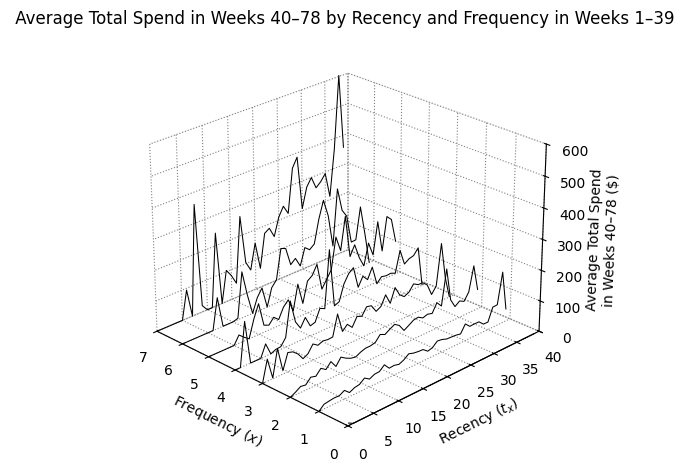

In [11]:
import matplotlib.pyplot as plt

X, Y = np.meshgrid(np.arange(8), np.arange(40))
Z = (test.to_numpy()[:,1:]/100).astype(np.float32)

fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

ax.plot_wireframe(X, Y, Z, rstride=0, cstride=1, color='black', linewidth=0.75)
ax.set_xlabel('Frequency ($x$)')
ax.set_ylabel('Recency ($t_{x}$)')
ax.set_zlabel('Average Total Spend\nin Weeks 40–78 ($)')
ax.set_title(" Average Total Spend in Weeks 40–78 by Recency and Frequency in Weeks 1–39")

ax.view_init(elev=25, azim=-45, roll=0) 

ax.set_xlim(7, 0)  
ax.set_ylim(0, 40) 
ax.set_zlim(0, 600) 

ax.grid(True, linestyle=':', color='lightgray')

ax.xaxis._axinfo['grid'].update({'linestyle': ':', 'color': 'gray'})
ax.yaxis._axinfo['grid'].update({'linestyle': ':', 'color': 'gray'})
ax.zaxis._axinfo['grid'].update({'linestyle': ':', 'color': 'gray'})

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Contour Plot Of Average Week 40–78 Total Spend By Recency And Frequency')

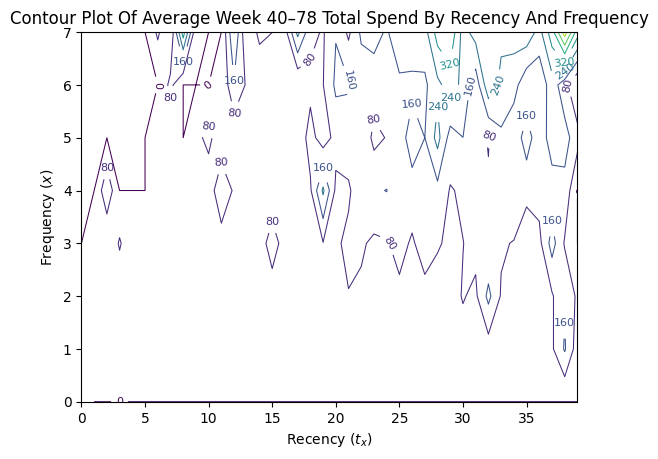

In [12]:
X, Y = np.meshgrid(np.arange(0,40,1), np.arange(8))
Z = (test.to_numpy()[:,1:]/100).astype(np.float32).T

cs = plt.contour(X, Y, Z, linewidths=0.75)
plt.clabel(cs, fontsize=8)
plt.xlabel('Recency ($t_{x}$)')
plt.ylabel('Frequency ($x$)')
plt.title('Contour Plot Of Average Week 40–78 Total Spend By Recency And Frequency')